# Section 1: binary phase evaluation (fixed parameters)

We model a binary system embedded in an accretion disk, along with a dark matter spike and gravitational waves emission.
The goal for our modelization is to produce an estimate of the following quantity: 

\begin{equation}
    \dot{r} = \dot{r}_{\mathrm{gas}} + \dot{r}_{\mathrm{DF}} + \dot{r}_{\mathrm{GW}}\text{,}
\end{equation}

where $\dot{r}_\mathrm{gas}$ is the contribution coming from gas torques from the accretion disk surrounding the binary, $\dot{r}_\mathrm{DF}$ is the effect of dynamical friction from the presence of the dark matter spike, and $\dot{r}_\mathrm{GW}$ is the contribution from the gravitational waves emission. Specifically, we adopt the classical Newtonian formalism, computing the results from the reduced mass-system, and in case assuming that $m_1 \gg m_2$.

Once the shape of $\dot{r}$ is clear, one can evaluate the phase of the binary system from a generic $f$-frequency to the $f_{\mathrm{isco}}$-frequency. Assuming circular orbits the frequency is:

\begin{equation}
    f = \frac{1}{\pi} \sqrt{\frac{G(m_1 + m_2)}{r^3}}\text{.}
\end{equation}

We can evaluate $\Phi(f)$ as: 

\begin{equation}
    \Phi(f) = 2 \pi \int_{f}^{f_{\mathrm{isco}}} \frac{dt}{df'} f' df'\text{,}
\end{equation}

where the relation $\frac{dt}{df'}$ is extracted directly from the expression in the above equation by the following chain rule: $\frac{dr}{dt} \frac{df}{dr} = \frac{df}{dt}$. 

## Expressions for the $\dot{r}_i$ contributions

- Accretion disk's torques: 

\begin{equation}
    \dot{r}_\mathrm{gas} = - 2 \Sigma_0 \frac{r^{\gamma + 3/2}}{r_0^\gamma} \frac{G^{1/2} (m_1 + m_2)^{1/2}}{\mu} q^{2} \mathcal{M}^2\text{.}
\end{equation}

- Dark matter spike's dynamical friction:

Static:

\begin{equation}
\label{eq:r_dot_DF}
    \dot{r}_{\mathrm{DF}} = - \frac{8 \pi G^{\frac{1}{2}} \mu \log{(\Lambda)} \rho_6 r_6^{\gamma_s} \xi(v)}{r^{\gamma_s - \frac{5}{2}}(m_1 + m_2)^{\frac{3}{2}}}\text{,}
\end{equation}

Time dependent: in this case only the phase has an analytical form, which is derived from the fit of the outcomde of the HaloFeedback code evolving the static dress as the binary evolves. 

\begin{equation}
\label{eq:phi_time}
    \Phi(f) = \Phi_{\mathrm{GW}} \cdot (1 - \eta \cdot y^{-\lambda}(1 - 2F_{1}))
\end{equation}

where the quantities $\eta$, $\lambda$ and $y$ are derived from the frequencies and other constants set in the data (see below for the implementation), while $2F_1$ is the $\textbf{gaussian hypergeometric}$ function, and $\Phi_{\mathrm{GW}}$ is the vacuum phase to coalescence that comes from integrating the below quantity. If we reverse the process to find $\Phi(f)$, it is possible to find an expression for $\dot{r}_{\mathrm{eff, dm}}$, but I will not report it here.

- Gravitational waves: 

\begin{equation}
\label{eq:r_dot_gw}
    \dot{r}_{\mathrm{GW}} = - \frac{64 (m_1 + m_2) G^3 m_1 m_2}{5 c^5 r^3}\text{.}
\end{equation}

In the code, there will be enabled the possibility to choose which of these options to keep in the final formula, which will account for the sum of all the contributions the user requires. 

## Formulas to use and implement "in code" for the phase evaluation

I used the following quantities: 

- Derivative of f in radial separation:

\begin{equation}
\label{eq:dfdr}
    \frac{df}{dr} = \frac{1}{\pi} (-\frac{3}{2}) \sqrt{\frac{G (m_1 + m_2)}{r^5}}\text{.}\\
\end{equation}


- Inverse of f(r):

\begin{equation}
\label{eq:r(f)}
    r(f) = \sqrt[3]{\frac{G (m_1 + m_2)}{\pi^2 f^2}}\text{,}\\
\end{equation}

- Derivative of f in time:

\begin{equation}
\label{eq:dfdt}
    \frac{df}{dt} = \dot{r} \frac{df}{dr}\text{,}\\
\end{equation}

- Second derivative of the phase in time:

\begin{equation}
\label{eq:phi_dot-dot}
    \ddot{\Phi}(f) = 4 \pi^2 f \left(\frac{d\Phi(f)}{df}\right)^{-1} 
\end{equation}

# Code implementation

### Libraries and classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy as sp
from scipy.integrate import quad_vec, simpson
from scipy.special import hyp2f1, betainc
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from matplotlib.colors import LogNorm
from scipy.integrate import cumulative_trapezoid, cumulative_simpson
from scipy.interpolate import CubicSpline
from scipy.integrate import quad, solve_ivp, simps
from scipy.interpolate import interp1d

In [2]:
# Define some constants: 

G = 6.67408e-11 # kg^-1 m^3 / s^2
c = 299792458.0 # m / s
pc = 3.08567758149137e16 # m
m_sun = 1.98855e30 # kg

## General functions

Below we find a bunch of functions to perform useful operations throughout the code.

- To find the analytical phase to coalescence:

In [3]:
def hypgeom_scipy(theta, y):
        '''Compute the hypergeometric function using scipy.'''
        return hyp2f1(1, theta, 1 + theta, -y**(-5 / (3*theta)))

def hyp2f1_derivative(hyp2f1, f):
        '''Finds derivative of the gauss_hypergeom function through differentiation.'''
        delta_function = np.concatenate(([np.min(hyp2f1)], hyp2f1[1:] - hyp2f1[:-1]))
        delta_fs = np.concatenate(([np.max(f)], f[1:] - f[:-1]))
        return delta_function/delta_fs
    
def find_cf(m1, gammas, M_tot, r_s, rho_s, epsv, logL):

    return 5 * c**5 / (8 * m1**2) * np.pi**(2 * (gammas - 4) / 3) * G**(-(2 + gammas) / 3) * M_tot**((1 - gammas)/3) * r_s**(gammas) * epsv * rho_s * logL

- To find the numerical phase to coalescence

In [4]:
def df_dt(df_dr, dot_r): 
    '''Finds the binary frequency time derivative.'''
    return df_dr * dot_r

def to_integrate(f, df_dt):
    function = 2 * np.pi * df_dt**(-1) * f 
    return interp1d(f, function, kind='cubic')

def phase_f(f, df_dt):
    '''Finds the binary phase as a function of frequency.'''
    to_integrate_f = to_integrate(f, df_dt)
    
    # Differential equation for the phase
    def phase_ode(f, y):
        return to_integrate_f(f)
    
    # Initial condition
    y0 = [0]
    
    # Solving the IVP
    result = solve_ivp(phase_ode, [f[0], f[-1]], y0, t_eval=f, rtol=1e-14, atol=1e-14)
    
    # Extracting the solution
    phase_f = result.y[0]
    
    return phase_f

- From the $\texttt{pydd}$ code on GitHub (
https://github.com/pipcole/pydd/blob/main/src/pydd/binary.py#L45 
):

In [5]:
# Conversion functions

def get_r_s(m_1, rho_s, gamma_s):
    return ((3 - gamma_s) * 0.2 ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    
def get_rho_s(rho_6, m_1, gamma_s):
    a = 0.2
    r_6 = 1e-6 * pc
    m_tilde = ((3 - gamma_s) * a ** (3 - gamma_s)) * m_1 / (2 * np.pi)
    return (rho_6 * r_6 ** gamma_s / (m_tilde ** (gamma_s / 3))) ** (1 / (1 - gamma_s / 3))

def get_rho_6(rho_s, m_1, gamma_s):
    a = 0.2
    r_s = ((3 - gamma_s) * a ** (3 - gamma_s) * m_1 / (2 * np.pi * rho_s)) ** (1 / 3)
    r_6 = 1e-6 * pc
    return rho_s * (r_6 / r_s) ** -gamma_s

## Environments 

I below will implement a class for each of the environment of study. This will allow me to compute the different $\dot{r}$ separately, and then use them in a more general function evaluating the phase to coalescence.

### Vacuum Binary

In [6]:
class VacuumBinary:
    
    """
    VacuumBinary

    Overview:
    Initializes an environment for a vacuum binary system, evaluates the derivative of the radius, and aids in finding the phase to coalescence of the binary system.

    Attributes:
    ----------
    m1 : float
        Mass of the first body in kilograms.
    
    m2 : float
        Mass of the second body in kilograms.
    
    mu : float
        Reduced mass of the binary system.
    
    q : float
        Mass ratio of the binary system (m2/m1).
    
    M_tot : float
        Total mass of the binary system.
    
    dist : float
        Distance to the binary system.
    
    chirp_mass : float
        Chirp mass of the binary system, relevant for gravitational wave calculations.

    Methods:
    -------
    frequency(r: float) -> float
        Finds the binary frequency assuming circular orbits, at fixed radius r.

    radius(f: float) -> float
        Finds the binary radius assuming circular orbits, at fixed frequency f.

    df_dr(r: float) -> float
        Finds the binary frequency radial derivative assuming circular orbits.

    vacuum_phase(r: float) -> float
        Analytical vacuum phase solution, integral from frequency to innermost stable circular orbit (ISCO) frequency.

    dvacuum_phase_df(r: float) -> float
        Analytical derivative of the vacuum phase solution with respect to frequency.

    dot_r_gw(r: float) -> float
        Finds the derivative of radial separation in the vacuum case.

    Examples:
    --------
    >>> binary = VacuumBinary(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20)
    >>> r = 1e7  # example radius
    >>> freq = binary.frequency(r)
    >>> phase = binary.vacuum_phase(r)
    >>> dr_dt = binary.dot_r_gw(r)
    """
    
    def __init__(self, m1, m2, dist): 
        
        """
        Initializes the VacuumBinary class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        """
        
        self.m1 = m1
        self.m2 = m2
        self.mu = self.m1 * self.m2 / (self.m1 + self.m2)
        self.q = self.m2/self.m1
        self.M_tot = self.m1 + self.m2
        self.dist = dist
        self.chirp_mass = (self.m1 * self.m2)**(3/5) / (self.M_tot)**(1/5)   
    
    def frequency(self, r):
        return 1 / np.pi * np.sqrt(G * self.M_tot / r**3)
    
    def radius(self, f):
        return (G * self.M_tot / (f**2 * np.pi**2))**(1/3)
    
    def df_dr(self, r): 
        return 1 / np.pi * (-3/2) * np.sqrt(G * self.M_tot / r**5)
    
    def vacuum_phase(self, r):
        freqs = self.frequency(r)
        r_isco = 6 * self.m1 * G / c**2
        f_isco = self.frequency(r_isco)
        return 1/16 * (c**3 / (np.pi * G * self.chirp_mass))**(5/3) * (-freqs**(-5/3) + f_isco**(-5/3))
    
    def dvacuum_phase_df(self, r):
        freqs = self.frequency(r)
        return 1/16 * (c**3 / (np.pi * G * self.chirp_mass))**(5/3) * (-5/3) * (-freqs**(-5/3-1))
    
    def dot_r_gw(self, r):
        return - 64 * self.M_tot * G**3 * self.m1 * self.m2 / (5 * c**5 * r**3)
        

### Accretion Disk

In [7]:
class AccretionDisk: 
    
    """
    AccretionDisk

    Overview:
    Initializes an environment for a binary system embedded in an accretion disk, evaluates the surface density and density profile of the disk, and calculates torques and radial separation derivatives within the disk.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    mach : float
        Mach number characterizing the disk.

    sigma0 : float
        Surface density normalization constant.

    alpha : float
        Power-law index for the surface density profile.

    r0 : float
        Reference radius for the surface density normalization.

    Methods:
    -------
    sigma_acc(r: float) -> float
        Finds the surface density profile of an accretion disk.

    rho_disk(r: float) -> float
        Finds the density profile of the disk using \rho ≈ Σ(r) / (2h), where h = r / Mach.

    gas_torque(r: float) -> float
        Finds the gas torque on the secondary component of the binary.

    dot_r_acc(r: float) -> float
        Finds the derivative of radial separation within an accretion disk.

    Examples:
    --------
    >>> disk = AccretionDisk(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20, 10, 1e3, -1, 1e9)
    >>> r = 1e7  # example radius
    >>> sigma = disk.sigma_acc(r)
    >>> rho = disk.rho_disk(r)
    >>> torque = disk.gas_torque(r)
    >>> dr_dt = disk.dot_r_acc(r)
    """
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, r0):
        
        """
        Initializes the AccretionDisk class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        mach : float
            Mach number characterizing the disk.
        
        sigma0 : float
            Surface density normalization constant.
        
        alpha : float
            Power-law index for the surface density profile.
        
        r0 : float
            Reference radius for the surface density normalization.
        """
        
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        self.mach = mach
        self.sigma0 = sigma0
        self.alpha = alpha
        self.r0 = r0
        
    def sigma_acc(self, r):
        return self.sigma0 * (r / self.r0)**(self.alpha)

    def rho_disk(self, r):
        h = r / self.mach
        return self.sigma_acc(r) / (2 * h) 
    
    def gas_torque(self, r):
        omega_2 = G * self.Binary_init.M_tot / r**3
        return - self.sigma_acc(r) * r**4 * self.Binary_init.q**2 * self.mach**2
    
    def dot_r_acc(self, r):
        r_dot_acc = 2 * self.gas_torque(r) / self.Binary_init.mu * np.sqrt(r / (G * self.Binary_init.M_tot))
        return r_dot_acc

### Dark Matter

In [8]:
class DarkMatter: 
    
    """
    DarkMatter

    Overview:
    Initializes an environment for a binary system embedded in a dark matter spike, evaluates the dark matter density profile, and calculates the radial separation derivatives in a dark matter environment.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    logL : float
        The Coulomb logarithm.

    gammas : float
        Slope of the dark matter density profile.

    rho6 : float
        Density normalization constant at radius r6.

    r6 : float
        Reference radius for the density normalization.

    epsv : float
        Velocity dispersion parameter.

    Methods:
    -------
    rho_dm(r: float) -> float
        Finds the density profile of the dark matter using the specified formulation.

    dot_r_dm_s(r: float) -> float
        Finds the derivative of radial separation within a static dark matter environment.

    dot_r_dm_eff(r: float) -> float
        Finds the derivative of radial separation considering an effective dark matter environment from previous numerical fits on the HaloFeedback algorithm.

    Examples:
    --------
    >>> dm = DarkMatter(1.4 * 1.989e30, 1.4 * 1.989e30, 1e20, 0.1, 1e-2, 1e3, 1e9, 0.1)
    >>> r = 1e7  # example radius
    >>> rho = dm.rho_dm(r)
    >>> dr_dt_s = dm.dot_r_dm_s(r)
    >>> dr_dt_eff = dm.dot_r_dm_eff(r)
    """
    
    def __init__(self, m1, m2, dist, q, gammas, rho6, r6, epsv):
        
        """
        Initializes the DarkMatter class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        q : float
            Mass ratio parameter.

        gammas : float
            Slope of the dark matter density profile.
        
        rho6 : float
            Density normalization constant at radius r6.
        
        r6 : float
            Reference radius for the density normalization.
        
        epsv : float
            Velocity dispersion parameter.
        """
    
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        self.logL = 1 / np.sqrt(q)
        self.gammas = gammas
        self.rho6 = rho6
        self.r6 = r6
        self.epsv = epsv
    
    def rho_dm(self, r):
        return self.rho6 * (self.r6 / r)**(self.gammas)
    
    def dot_r_dm_s(self, r):
        r_dot_dm = - 8 * np.pi * G**(1/2) * self.Binary_init.mu * self.logL * self.rho_dm(r) * r**(5/2) * self.epsv / self.Binary_init.M_tot**(3/2)
        return r_dot_dm
    
    def dot_r_dm_eff(self, r):

        freqs = self.Binary_init.frequency(r)
        df_dr_s = self.Binary_init.df_dr(r)
        
        # Vacuum 
        
        phase_vacuum = self.Binary_init.vacuum_phase(r)
        dphase_vacuum_df = self.Binary_init.dvacuum_phase_df(r)
        
        # Constants
        
        rho_s = get_rho_s(self.rho6, self.Binary_init.m1, self.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.gammas)
        
        gamma_e = 5/2 
        cf = find_cf(self.Binary_init.m1, self.gammas, self.Binary_init.M_tot, r_s, rho_s, self.epsv, self.logL)
        f_eq = cf**(3 / (11 - 2 * self.gammas))
        theta = 5 / (2 * gamma_e)
        lambda_ = (11 - 2 * (self.gammas + gamma_e)) / 3
        
        alpha_1 = 1.4412
        alpha_2 = 0.4511
        beta = 0.8163
        xi = - 0.4971
        gamma_r = 1.4396
        f_b = beta * (self.Binary_init.m1 / (1000 * m_sun))**(-alpha_1) * (self.Binary_init.m2 / m_sun)**(alpha_2) * (1 + xi * np.log(self.gammas/gamma_r))
        
        f_t = f_b
        eta = (5 + 2*gamma_e) / (2 * (8 - self.gammas)) * (f_eq / f_b)**((11 - 2 * self.gammas) / 3)
        
        # Variables 
    
        y = freqs / f_t
        dy_df = 1 / f_t
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        dgauss_hypergeom_df = hyp2f1_derivative(gauss_hypergeom, freqs)
        
        # Find phase derivative in frequency
        
        exp_y = y**(-lambda_)
        d_phase_df_s = dphase_vacuum_df - (dphase_vacuum_df * eta * exp_y + phase_vacuum * eta * (-lambda_) * exp_y/y * dy_df) + eta * (-lambda_ * exp_y/y * phase_vacuum * dy_df * gauss_hypergeom + exp_y * dphase_vacuum_df * gauss_hypergeom + exp_y * phase_vacuum * dgauss_hypergeom_df)
        
        df_dt = 2 * np.pi * freqs / d_phase_df_s
        
        return df_dt * df_dr_s**(-1)

In [9]:
class Phase_Evaluation_check: 
    
    """
    Phase_Evaluation_check

    Overview:
    This class initializes various environments for a binary system, including vacuum, accretion disk, and dark matter spike, and evaluates the phase to coalescence for each environment.

    Attributes:
    ----------
    Binary_init : VacuumBinary
        An instance of the VacuumBinary class representing the binary system.

    Acc_init : AccretionDisk
        An instance of the AccretionDisk class representing the binary system within an accretion disk environment.

    DM_init : DarkMatter
        An instance of the DarkMatter class representing the binary system within a dark matter spike environment.

    Methods:
    -------
    _Phi_to_c_indef_s(r: float) -> float
        Compute indefinite phase to coalescence for static dark matter.

    _Phi_to_c_s(r: float) -> float
        Compute phase to coalescence for static dark matter.

    _Phi_to_c_indef_v(r: float) -> float
        Compute indefinite phase to coalescence for vacuum.

    _Phi_to_c_v(r: float) -> float
        Compute phase to coalescence for vacuum.

    phase_effective_dm(r: float) -> float
        Finds the effective phase from fitting results from the HaloFeedback algorithm.

    Examples:
    --------
    >>> pec = Phase_Evaluation_check(m1=1.4 * 1.989e30, m2=1.4 * 1.989e30, dist=4e9, mach=10, sigma0=1e-2, alpha=0.5, gammas=1, rho6=1e3, r6=1e2, r0=1e7, epsv=0.1)
    >>> r = 1e7  # example radius
    >>> phi_vacuum = pec._Phi_to_c_v(r)
    >>> phi_static_dm = pec._Phi_to_c_s(r)
    >>> phi_effective_dm = pec.phase_effective_dm(r)
    """
    
    def __init__(self, m1, m2, dist, mach, sigma0, alpha, gammas, rho6, r6, r0, epsv): 
        
        """
        Initializes the Phase_Evaluation_check class.

        Parameters:
        ----------
        m1 : float
            Mass of the first body in kilograms.
        
        m2 : float
            Mass of the second body in kilograms.
        
        dist : float
            Distance to the binary system.
        
        mach : float
            Mach number of the accretion disk.
        
        sigma0 : float
            Surface density normalization constant of the accretion disk.
        
        alpha : float
            Power-law index of the surface density profile of the accretion disk.
        
        gammas : float
            Slope of the dark matter density profile.
        
        rho6 : float
            Density normalization constant at radius r6 for the dark matter.
        
        r6 : float
            Reference radius for the dark matter density normalization.
        
        r0 : float
            Reference radius for the accretion disk.
        
        epsv : float
            Velocity dispersion parameter for the dark matter.
        """
        
        self.Binary_init = VacuumBinary(m1 = m1, m2 = m2, dist = dist)
        
        self.Acc_init = AccretionDisk(mach=mach, 
                           m1=m1,
                           m2=m2, 
                           dist=4e9,
                           sigma0=sigma0, 
                           alpha=alpha, 
                            r0=r0)

        self.DM_init = DarkMatter(m1=m1, 
                        m2=m2, 
                        dist=4e9, 
                        q=m2/m1, 
                        gammas=gammas, 
                        rho6=rho6, 
                        r6=r6, 
                        epsv=epsv)

    def _Phi_to_c_indef_s(self, r):
        '''Compute indefinite phase to coalescence for static dm.'''
        freqs = self.Binary_init.frequency(r)
        
        rho_s = get_rho_s(self.DM_init.rho6, self.Binary_init.m1, self.DM_init.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.DM_init.gammas)
        
        y = freqs / (find_cf(self.Binary_init.m1, self.DM_init.gammas, self.Binary_init.M_tot, r_s, rho_s, self.DM_init.epsv, self.DM_init.logL)**(3 / (11 - 2 * self.DM_init.gammas)))
        a_v = 1 / 16 * (c ** 3 / (np.pi * G * self.Binary_init.chirp_mass)) ** (5/3)
        theta = 5 / (11 - 2 * self.DM_init.gammas)
        
        return a_v / freqs ** (5 / 3) * hypgeom_scipy(theta, y)
    
    
    def _Phi_to_c_s(self, r):
        '''Compute phase to coalescence for static dm.'''
        r_isco = 6 * self.Binary_init.m1 * G / c**2
        return self._Phi_to_c_indef_s(r) -  self._Phi_to_c_indef_s(r_isco)
    
    def _Phi_to_c_indef_v(self, r):
        '''Compute indefinite phase to coalescence for vacuum.'''
        freqs = self.Binary_init.frequency(r)
        a_v = 1/16 * (c ** 3 / (np.pi * G * self.Binary_init.chirp_mass))**(5/3)
        return a_v / freqs**(5/3)
    
    def _Phi_to_c_v(self, r):
        '''Compute phase to coalescence for vacuum.'''
        r_isco = 6 * self.Binary_init.m1 * G / c**2
        return self._Phi_to_c_indef_v(r) -  self._Phi_to_c_indef_v(r_isco)
    
    def phase_effective_dm(self, r):
    
        '''Finds the effective phase from fitting results from HaloFeedback algorithm.'''
        
        freqs = self.Binary_init.frequency(r)
        
        # Constants
        
        rho_s = get_rho_s(self.DM_init.rho6, self.Binary_init.m1, self.DM_init.gammas)
        r_s = get_r_s(self.Binary_init.m1, rho_s, self.DM_init.gammas)
        
        gamma_e = 5/2 
        cf = find_cf(self.Binary_init.m1, self.DM_init.gammas, self.Binary_init.M_tot, r_s, rho_s, self.DM_init.epsv, self.DM_init.logL)
        f_eq = cf**(3 / (11 - 2 * self.DM_init.gammas))
        theta = 5 / (2 * gamma_e)
        lambda_ = (11 - 2 * (self.DM_init.gammas + gamma_e)) / 3
        
        alpha_1 = 1.4412
        alpha_2 = 0.4511
        beta = 0.8163
        xi = - 0.4971
        gamma_r = 1.4396
        f_b = beta * (self.Binary_init.m1 / (1000 * m_sun))**(-alpha_1) * (self.Binary_init.m2 / m_sun)**(alpha_2) * (1 + xi * np.log(self.DM_init.gammas/gamma_r))
        
        f_t = f_b
        eta = (5 + 2*gamma_e) / (2 * (8 - self.DM_init.gammas)) * (f_eq / f_b)**((11 - 2 * self.DM_init.gammas) / 3)
        
        # Variables:
        
        f_t = f_b
        y = freqs / f_t
        phase_vacuum = self._Phi_to_c_v(r)
        
        # Hypergeometric function
        
        gauss_hypergeom = hyp2f1(1, theta, 1 + theta, - y**(-5/(3 * theta)))
        
        return phase_vacuum * (1 - eta * y**(-lambda_) * (1 - gauss_hypergeom))

# Section 1: binary phase evaluation VARYING parameters

We work varying parameters one by one. More specifically we'll change:

### For the accretion disk:

- The $\gamma$ parameter $\rightarrow \ [-0.4, -0.7]$ ($\beta$-disk regime), possibly changing the upper threshold to match an $\alpha$-disk. Particularly, the scaling relations go as: 

$$\Sigma_\alpha = 5.14 \cdot 10^3 (\frac{\alpha}{0.1})^{-1} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{-1} (\frac{r}{10 M_1})^{3/2} \ \text{kg m}^{-2} ;$$

$$\Sigma_\beta = 2.1 \cdot 10^7 (\frac{\alpha}{0.1})^{-4/5} (\frac{f_{\mathrm{edd}}}{0.1} \frac{0.1}{\epsilon})^{3/5} (\frac{M_1}{10^6 M_{\odot}})^{1/5} (\frac{r}{10 M_1})^{-3/5}.$$

- $\Sigma_0$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 

### For the effective dark matter spike:

- The $\gamma_s$ parameter $\rightarrow \ [2, 2.5]$;
- $\rho_m$, just vary from some orders of magnitude and see which produces unphysical stuff; 
- $m_1$ from $1000 M_{\odot} \text{to} \ 10^6 M_{\odot}$. 


We look to see how changing just one of these parameters will affect the inspiral. If the dephasing $\Delta\Phi$ increases, this means that the environmental effect is more likely to be detected, while the opposite indicates that a vacuum model wil still be compatible with the phase measured. 

In [10]:
# Fix parameters:

m1 = 1e5 * m_sun #1.4e3 * m_sun
m2 = 10 * m_sun #1.4 * m_sun
q = m2/m1
M_tot = m1 + m2
mu = m1 * m2 / M_tot
chirp_mass = (m1 * m2)**(3/5) / (M_tot)**(1/5)

# Fix environments:

# Spike

rho6 = 1.17e17 * m_sun / pc**3
r6 =  pc / 1e6
gammas = 7/3
epsv = 0.58
logL = 1 / q**(1/2)

# Accretion disk

r_s = 2 * G * m1/ c**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100 
sigma0 = 1.5e10 / Mach**2
alpha = -1/2

In [28]:
# Build grid of vals

f_LISA = 1e-3 # Hz
r_max = vacuum_binary.radius(f_LISA)

r_isco = 6 * m1 * G / c**2
f_isco = vacuum_binary.frequency(r_isco)

print('isco frequency', f_isco)

# set grid of radial distances
r_grid = np.linspace(r_isco, r_max, int(1e4))

freqs = vacuum_binary.frequency(r_grid)

isco frequency 0.04397229680540114


## Accretion disk:

In [43]:
# Build array of gamma values, m_s, and sigma_0s

alpha_vals = np.linspace(-0.7, 1.5, 20)
m1_vals = np.logspace(3, 6, 20)
sigma0_vals = np.logspace(8, 11, 20)

print("Alphas: ", alpha_vals)
print("M1s: ", m1_vals)
print("Sigma0s: ", sigma0_vals)

Alphas:  [-0.7        -0.58421053 -0.46842105 -0.35263158 -0.23684211 -0.12105263
 -0.00526316  0.11052632  0.22631579  0.34210526  0.45789474  0.57368421
  0.68947368  0.80526316  0.92105263  1.03684211  1.15263158  1.26842105
  1.38421053  1.5       ]
M1s:  [   1000.            1438.44988829    2069.13808111    2976.35144163
    4281.33239872    6158.48211066    8858.6679041    12742.74985703
   18329.80710832   26366.5089873    37926.90190732   54555.94781169
   78475.99703515  112883.78916847  162377.67391887  233572.14690901
  335981.82862838  483293.02385718  695192.79617756 1000000.        ]
Sigma0s:  [1.00000000e+08 1.43844989e+08 2.06913808e+08 2.97635144e+08
 4.28133240e+08 6.15848211e+08 8.85866790e+08 1.27427499e+09
 1.83298071e+09 2.63665090e+09 3.79269019e+09 5.45559478e+09
 7.84759970e+09 1.12883789e+10 1.62377674e+10 2.33572147e+10
 3.35981829e+10 4.83293024e+10 6.95192796e+10 1.00000000e+11]


### Varying $\alpha$:

In [17]:
# Initialize system

vacuum_binary = VacuumBinary(
    m1=m1,
    m2=m2,
    dist=4e9 #pc
)

accretion_disk_alpha = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha_vals[i]
) for i in range(0, len(alpha_vals))]

accretion_disk = AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
)

dark_matter = DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
)

In [55]:
# Calculate phase to coalescence

phase_gw = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), vacuum_binary.dot_r_gw(r_grid)))
phase_acc = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), accretion_disk_alpha[i].dot_r_acc(r_grid) + vacuum_binary.dot_r_gw(r_grid))) for i in range(0, len(accretion_disk_alpha))]
phase_dm_eff = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid)))
phase_all = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid) + accretion_disk_alpha[i].dot_r_acc(r_grid))) for i in range(0, len(accretion_disk_alpha))]

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [57]:
# Fiducial value

phase_acc_fiducial = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), accretion_disk.dot_r_acc(r_grid) + vacuum_binary.dot_r_gw(r_grid)))
phase_dm_fiducial = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid)))
phase_all_fiducial = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid) + accretion_disk.dot_r_acc(r_grid)))

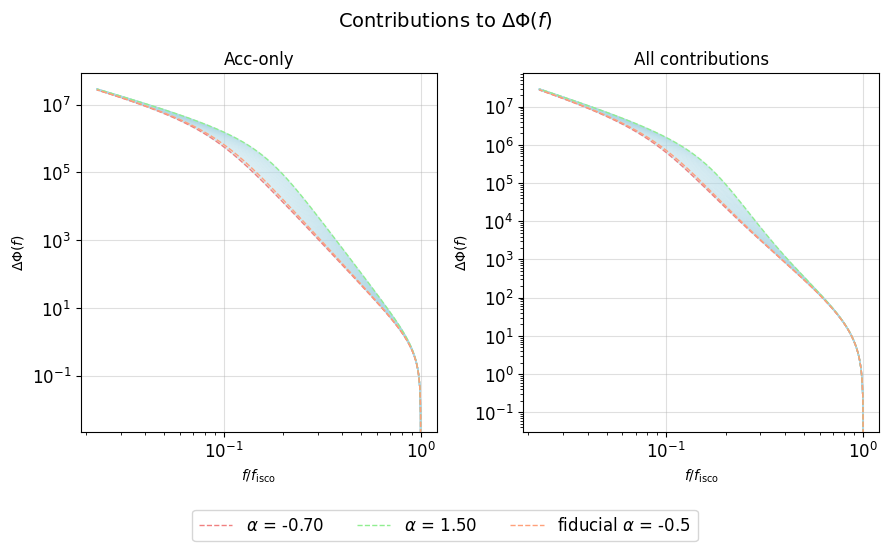

In [58]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_acc)):
    axs[0].loglog(freqs/f_isco, phase_acc[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_acc[0] - phase_gw, label=fr'$\alpha$ = {alpha_vals[0]:.2f}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_acc[-1] - phase_gw, label=fr'$\alpha$ = {alpha_vals[-1]:.2f}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=fr'fiducial $\alpha$ = -0.5', linestyle='--', linewidth=1, c='lightsalmon')
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines

for i in range(0, len(phase_acc)):
    axs[1].loglog(freqs/f_isco, phase_all[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_accretion_DELTA_phi.png')
plt.show()

## Varying $m_1$

In [44]:
# Build grid of vals

r_max_m1 = [vacuum_binary_m1[i].radius(f_LISA) for i in range(0, len(m1_vals))]

r_isco_m1 = 6 * m1_vals * m_sun * G / c**2
f_isco_m1 = [vacuum_binary_m1[i].frequency(r_isco_m1[i]) for i in range(0, len(m1_vals))]

# set grid of radial distances
r_grid_m1 = [np.linspace(r_isco_m1[i], r_max_m1[i], int(1e4)) for i in range(0, len(m1_vals))]

freqs_m1 = [vacuum_binary_m1[i].frequency(r_grid_m1[i])  for i in range(0, len(m1_vals))]

In [45]:
vacuum_binary_m1 = [VacuumBinary(
    m1=m1_vals[i] * m_sun,
    m2=m2,
    dist=4e9 #pc
) for i in range(0, len(m1_vals))]

accretion_disk_m1 = [AccretionDisk(
    mach=Mach, 
    m1=m1_vals[i] * m_sun,
    m2=m2,
    r0=r0, 
    dist=4e9,
    sigma0=sigma0, 
    alpha=alpha
) for i in range(0, len(m1_vals))]

dark_matter_m1 = [DarkMatter(
    m1=m1_vals[i] * m_sun, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
) for i in range(0, len(m1_vals))]

In [59]:
# Calculate phase to coalescence

phase_gw_m1 = [phase_f(freqs_m1[i], df_dt(vacuum_binary_m1[i].df_dr(r_grid_m1[i]), vacuum_binary_m1[i].dot_r_gw(r_grid_m1[i]))) for i in range(0, len(m1_vals))]
phase_acc_m1 = [phase_f(freqs_m1[i], df_dt(vacuum_binary_m1[i].df_dr(r_grid_m1[i]), accretion_disk_m1[i].dot_r_acc(r_grid_m1[i]) + vacuum_binary_m1[i].dot_r_gw(r_grid_m1[i]))) for i in range(0, len(m1_vals))]
phase_dm_eff_m1 = [phase_f(freqs_m1[i], df_dt(vacuum_binary_m1[i].df_dr(r_grid_m1[i]), dark_matter_m1[i].dot_r_dm_eff(r_grid_m1[i]))) for i in range(0, len(m1_vals))]
phase_all_m1 = [phase_f(freqs_m1[i], df_dt(vacuum_binary_m1[i].df_dr(r_grid_m1[i]), dark_matter_m1[i].dot_r_dm_eff(r_grid_m1[i]) + accretion_disk_m1[i].dot_r_acc(r_grid_m1[i]))) for i in range(0, len(m1_vals))]

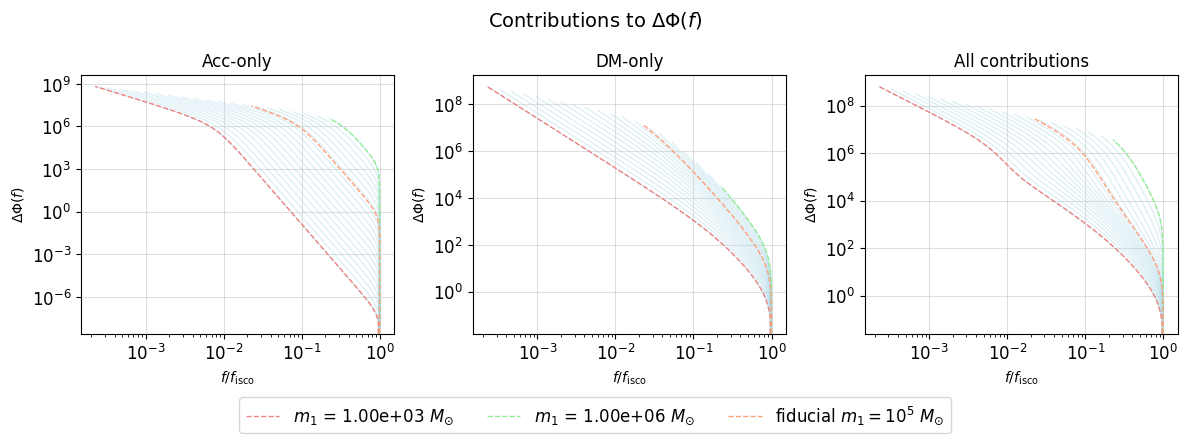

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(12,4))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(m1_vals)):
    axs[0].loglog(freqs_m1[i]/f_isco_m1[i], phase_acc_m1[i] - phase_gw_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs_m1[0]/f_isco_m1[0], -phase_gw_m1[0] + phase_acc_m1[0], label=f'$m_1$ = {m1_vals[0]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_acc_m1[-1], label=f'$m_1$ = {m1_vals[-1]:.2e} $M_{{\odot}}$', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=f'fiducial $m_1 = 10^5 \ M_{{\odot}}$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(m1_vals)):
    axs[1].loglog(freqs_m1[i]/f_isco_m1[i], -phase_gw_m1[i] + phase_dm_eff_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs_m1[0]/f_isco_m1[0], -phase_gw_m1[0] + phase_dm_eff_m1[0], linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_dm_eff_m1[-1], linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('DM-only')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(m1_vals)):
    axs[2].loglog(freqs_m1[i]/f_isco_m1[i], - phase_gw_m1[i] + phase_all_m1[i], c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[2].loglog(freqs_m1[0]/f_isco_m1[0],  -phase_gw_m1[0] + phase_all_m1[0], linestyle='--', linewidth=1, c='lightcoral')
axs[2].loglog(freqs_m1[-1]/f_isco_m1[-1], -phase_gw_m1[-1] + phase_all_m1[-1], linestyle='--', linewidth=1, c='lightgreen')
axs[2].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[2].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[2].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[2].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[2].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[2].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[2].grid(True, alpha=0.4)  # Add gridlines
axs[2].set_title('All contributions')  # Add gridlines
#axs[1, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/m1_DELTA_phi.png')
plt.show()

### Varying $\Sigma_0$

In [66]:
accretion_disk_sigma0 = [AccretionDisk(
    mach=Mach, 
    m1=m1,
    m2=m2,
    r0=r0, 
    dist=4e9,
    sigma0=sigma0_vals[i] / Mach**2, 
    alpha=alpha
) for i in range(0, len(sigma0_vals))]                

In [67]:
# Calculate phase to coalescence

phase_acc_sigma0 = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), accretion_disk_sigma0[i].dot_r_acc(r_grid) + vacuum_binary.dot_r_gw(r_grid))) for i in range(0, len(accretion_disk_sigma0))]
phase_all_sigma0 = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter.dot_r_dm_eff(r_grid) + accretion_disk_sigma0[i].dot_r_acc(r_grid))) for i in range(0, len(accretion_disk_sigma0))]

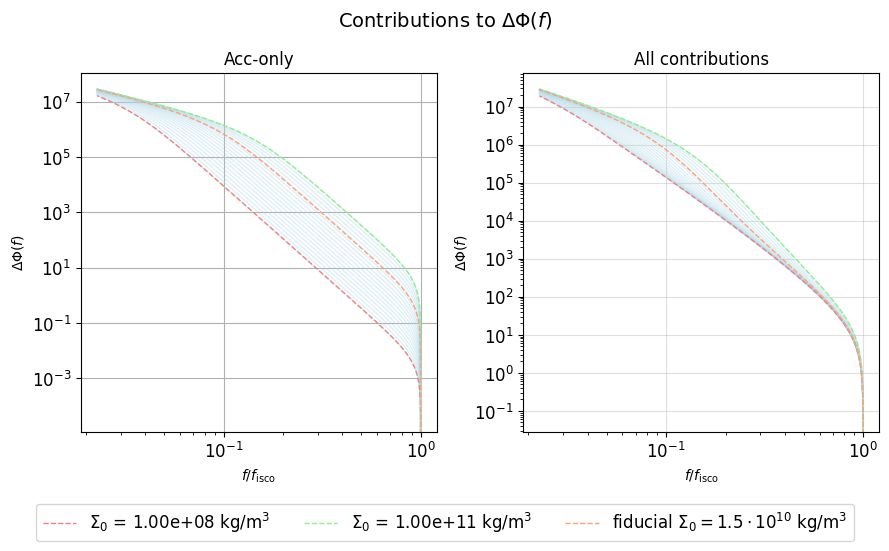

In [68]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_all_sigma0)):
    axs[0].loglog(freqs/f_isco, phase_acc_sigma0[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_acc_sigma0[0] - phase_gw, label=f'$\Sigma_0$ = {sigma0_vals[0]:.2e} kg/m$^3$', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_acc_sigma0[-1] - phase_gw, label=f'$\Sigma_0$ = {sigma0_vals[-1]:.2e} kg/m$^3$', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_acc_fiducial - phase_gw, label=f'fiducial $\Sigma_0 = 1.5 \cdot 10^{{10}}$ kg/m$^3$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Acc-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phase_all_sigma0)):
    axs[1].loglog(freqs/f_isco, phase_all_sigma0[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_sigma0[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_sigma0[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/sigma0_accretion_DELTA_phi.png')
plt.show()

## Dark matter spike

I still keep here the static profile, while in the other notebook I try to implement a version for the non-static profile.

In [69]:
# Build array of gamma_s values and rho_s

gammas_vals = np.linspace(2, 2.5, 20)
rhodm_vals = np.logspace(15, 18, 20)

print("Gammass: ", gammas_vals)
print("Rhodms: ", rhodm_vals)

Gammass:  [2.         2.02631579 2.05263158 2.07894737 2.10526316 2.13157895
 2.15789474 2.18421053 2.21052632 2.23684211 2.26315789 2.28947368
 2.31578947 2.34210526 2.36842105 2.39473684 2.42105263 2.44736842
 2.47368421 2.5       ]
Rhodms:  [1.00000000e+15 1.43844989e+15 2.06913808e+15 2.97635144e+15
 4.28133240e+15 6.15848211e+15 8.85866790e+15 1.27427499e+16
 1.83298071e+16 2.63665090e+16 3.79269019e+16 5.45559478e+16
 7.84759970e+16 1.12883789e+17 1.62377674e+17 2.33572147e+17
 3.35981829e+17 4.83293024e+17 6.95192796e+17 1.00000000e+18]


### Varying $\gamma_s$

In [71]:
dark_matter_gammas = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas_vals[i], 
    rho6=rho6, 
    r6=r6, 
    epsv=epsv
) for i in range(0, len(gammas_vals))]           

In [75]:
# Calculate phase to coalescence

phase_dm_gammas = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter_gammas[i].dot_r_dm_eff(r_grid))) for i in range(0, len(dark_matter_gammas))]
phase_all_gammas = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter_gammas[i].dot_r_dm_eff(r_grid) + accretion_disk.dot_r_acc(r_grid))) for i in range(0, len(dark_matter_gammas))]

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


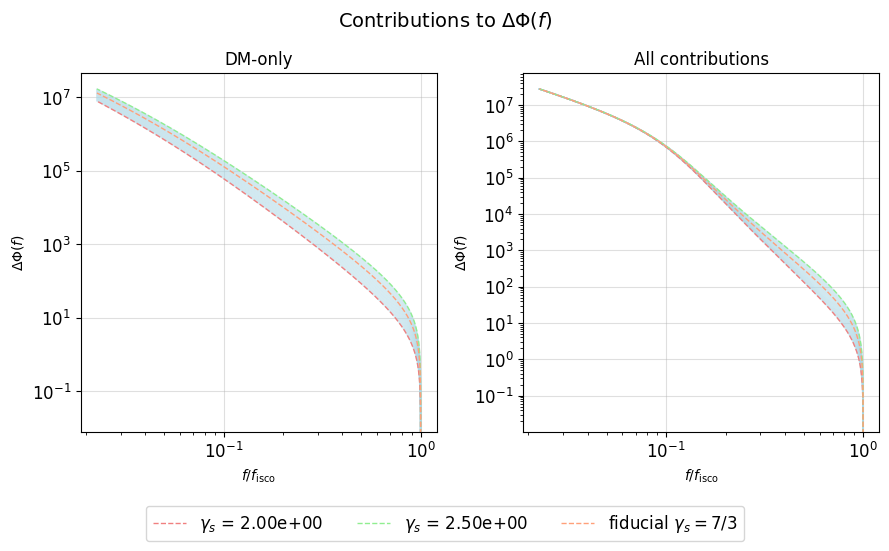

In [78]:
# Dephasing: 

fig, axs = plt.subplots(1, 2, figsize=(9,5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_dm_gammas)):
    axs[0].loglog(freqs/f_isco, phase_dm_gammas[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_dm_gammas[0] - phase_gw, label=f'$\gamma_s$ = {gammas_vals[0]:.2e}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_dm_gammas[-1] - phase_gw, label=f'$\gamma_s$ = {gammas_vals[-1]:.2e}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, label=f'fiducial $\gamma_s = 7/3$', linestyle='--', linewidth=1, c='lightsalmon')
#axs[0].axvline(x=1, c='green', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[0].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[0].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[0].grid(True, alpha=0.4)  # Add gridlines
axs[0].set_title('DM-only')  # Add gridlines
#axs[0, 0].ticklabel_format(scilimits=(-2,2), useMathText=True)

for i in range(0, len(phase_all_gammas)):
    axs[1].loglog(freqs/f_isco, phase_all_gammas[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_gammas[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_gammas[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
#axs[1].axvline(x=1, c='green', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].tick_params(axis='x', labelsize=12)  # Increase tick font size for x-axis
axs[1].tick_params(axis='y', labelsize=12)  # Increase tick font size for y-axis
axs[1].grid(True, alpha=0.4)  # Add gridlines
axs[1].set_title('All contributions')
#axs[0, 1].ticklabel_format(scilimits=(-2,2), useMathText=True)

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/gamma_dm_DELTA_phi.png')
plt.show()

### Varying $\rho_s$

In [81]:
dark_matter_rhos = [DarkMatter(
    m1=m1, 
    m2=m2, 
    dist=4e9, 
    q=q, 
    gammas=gammas, 
    rho6=rhodm_vals[i] * m_sun / pc**3, 
    r6=r6, 
    epsv=epsv
) for i in range(0, len(rhodm_vals))]                 

In [82]:
# Calculate phase to coalescence

phase_dm_rhos = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter_rhos[i].dot_r_dm_eff(r_grid))) for i in range(0, len(dark_matter_rhos))]
phase_all_rhos = [phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid), dark_matter_rhos[i].dot_r_dm_eff(r_grid) + accretion_disk.dot_r_acc(r_grid))) for i in range(0, len(dark_matter_rhos))]

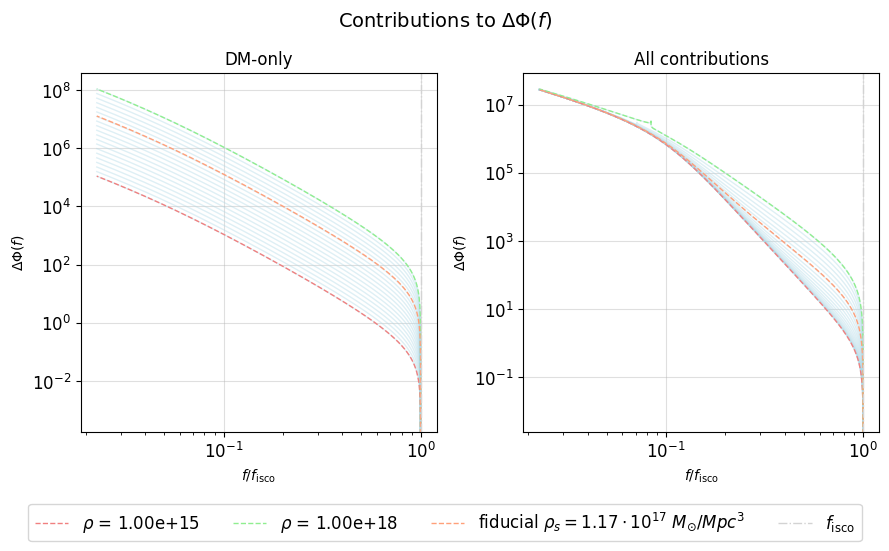

In [86]:


fig, axs = plt.subplots(1, 2, figsize=(9, 5))

plt.suptitle('Contributions to $\Delta\Phi(f)$', fontsize=14)

for i in range(0, len(phase_dm_rhos)):
    axs[0].loglog(freqs/f_isco, phase_dm_rhos[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[0].loglog(freqs/f_isco, phase_dm_rhos[0] - phase_gw, label=fr'$\rho$ = {rhodm_vals[0]:.2e}', linestyle='--', linewidth=1, c='lightcoral')
axs[0].loglog(freqs/f_isco, phase_dm_rhos[-1] - phase_gw, label=fr'$\rho$ = {rhodm_vals[-1]:.2e}', linestyle='--', linewidth=1, c='lightgreen')
axs[0].loglog(freqs/f_isco, phase_dm_fiducial - phase_gw, label=fr'fiducial $\rho_s = 1.17 \cdot 10^{{17}} \ M_{{\odot}} / Mpc^{{3}}$', linestyle='--', linewidth=1, c='lightsalmon')
axs[0].axvline(x=1, c='lightgrey', label='$f_{\mathrm{isco}}$', linestyle='-.', linewidth=1)
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)
axs[0].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)
axs[0].grid(True, alpha=0.4)
axs[0].set_title('DM-only')

for i in range(0, len(phase_all_rhos)):
    axs[1].loglog(freqs/f_isco, phase_all_rhos[i] - phase_gw, c='lightblue', linestyle='-', linewidth=1, alpha=0.4)
    
axs[1].loglog(freqs/f_isco, phase_all_rhos[0] - phase_gw, linestyle='--', linewidth=1, c='lightcoral')
axs[1].loglog(freqs/f_isco, phase_all_rhos[-1] - phase_gw, linestyle='--', linewidth=1, c='lightgreen')
axs[1].loglog(freqs/f_isco, phase_all_fiducial - phase_gw, linestyle='--', linewidth=1, c='lightsalmon')
axs[1].axvline(x=1, c='lightgrey', linestyle='-.', linewidth=1)
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
axs[1].grid(True, alpha=0.4)
axs[1].set_title('All contributions')

fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1, 0., 0.5), ncol=6, labelspacing=0.3, fontsize='large')
fig.tight_layout()
plt.savefig('results-images/rho_dm_DELTA_phi.png')
plt.show()

## Energy loss analysis

In the case of the accretion disk we saw that if the $\gamma$ coefficient is positive, then a sort of damp occurs in the dephasing plot. To assess the possible physics behind such behaviour, we try to see if the frequency at which the damping occurs corresponds to when the energy loss by the binary passes from an accretion-dominated regime to a GW-dominated one. 

In [87]:
def energy_loss_f(r, r_dot):
    
    return G * m1 * m2 * r_dot / (2 * r**2)

In [88]:
# Set a larger grid to see effect

r_grid_new = np.linspace(r_isco, 150 * r_isco, 10000)
freqs_new = vacuum_binary.frequency(r_grid_new)

In [91]:
r_dot_acc_gamma = (accretion_disk.dot_r_acc(r_grid_new)) 
r_dot_gw_gamma = (vacuum_binary.dot_r_gw(r_grid_new)) 

In [90]:
phase_gw_new = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid_new), vacuum_binary.dot_r_gw(r_grid_new)))
phase_acc_new = phase_f(freqs, df_dt(vacuum_binary.df_dr(r_grid_new), accretion_disk.dot_r_acc(r_grid_new) + vacuum_binary.dot_r_gw(r_grid_new)))

phi_c = phase_acc_new - phase_gw_new

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/scipy/integrate/_ivp/ivp.py:616: UserWarning: At least one element of `rtol` is too small. Setting `rtol = np.maximum(rtol, 2.220446049250313e-14)`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


In [92]:
energy_loss_acc = energy_loss_f(r_grid_new, r_dot_acc_gamma)
energy_loss_vac = energy_loss_f(r_grid_new, r_dot_gw_gamma)

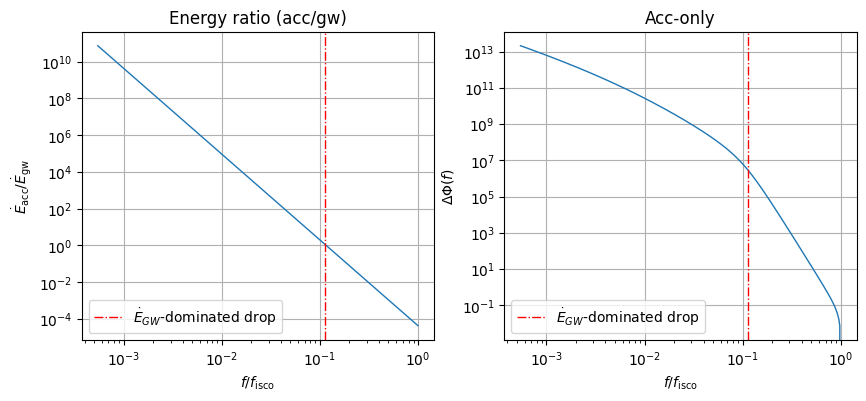

In [93]:
drop_estimate = np.where(energy_loss_acc/energy_loss_vac < 1.1)[0][-1]

fig, axs = plt.subplots(1, 2, figsize=(10,4))

axs[0].loglog(freqs_new/f_isco, energy_loss_acc/energy_loss_vac, linewidth=1)
axs[0].axvline(x=freqs_new[drop_estimate]/f_isco, c='red', linestyle='-.', linewidth=1, label='$\dot{E}_{GW}$-dominated drop')
axs[0].set_xlabel('$f/f_{\mathrm{isco}}$')
axs[0].set_ylabel(r'$\dot{E}_{\mathrm{acc}} / \dot{E}_{\mathrm{gw}}$')
axs[0].grid(True)  # Add gridlines
axs[0].set_title('Energy ratio (acc/gw)')

axs[1].loglog(freqs_new/f_isco, phi_c, linewidth=1)
axs[1].axvline(x=freqs_new[drop_estimate]/f_isco, c='red', linestyle='-.', linewidth=1, label='$\dot{E}_{GW}$-dominated drop')
axs[1].set_xlabel('$f/f_{\mathrm{isco}}$', fontsize=10)  # Increase x-label font size
axs[1].set_ylabel(r'$\Delta\Phi(f)$', fontsize=10)  # Add y-label with increased font size
axs[1].grid(True)  # Add gridlines
axs[1].set_title('Acc-only')

axs[1].legend(fontsize='medium')
axs[0].legend(fontsize='medium');